In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator'
}

In [3]:
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM simulator_20221220.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

Найдем глобальный CTR для двух контрольных групп.

In [4]:
ctr_control_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
ctr_control_0 = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()

In [5]:
ctr_control_1

0.20802680490126244

In [6]:
ctr_control_0

0.20823612262916305

Посчитаем поюзерные метрики в каждой группе.

In [7]:
linearized_likes_1 = df[df.exp_group == 1].likes - ctr_control_1 * df[df.exp_group == 1].views
linearized_likes_2 = df[df.exp_group == 2].likes - ctr_control_1 * df[df.exp_group == 2].views
linearized_likes_3 = df[df.exp_group == 3].likes - ctr_control_0 * df[df.exp_group == 3].views
linearized_likes_0 = df[df.exp_group == 0].likes - ctr_control_0 * df[df.exp_group == 0].views

Посмотрим гистограмму распределения поюзерного CTR в исходных группах 1 и 2

<AxesSubplot:xlabel='ctr', ylabel='Count'>

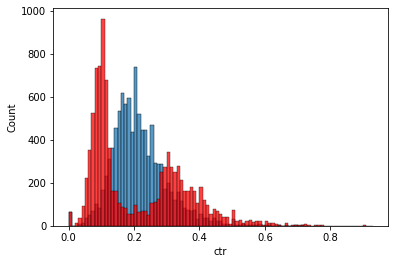

In [8]:
sns.histplot(df[df.exp_group == 1].ctr, binwidth = 0.01)
sns.histplot(df[df.exp_group == 2].ctr, color = 'r', binwidth = 0.01)

На графике видна сильная бимодальность во 2-ой группе. Посмотрим на новую метрику, возможна она изменится.

Построим гистограмму распределения новой метрики для 1 и 2 групп.

<AxesSubplot:ylabel='Count'>

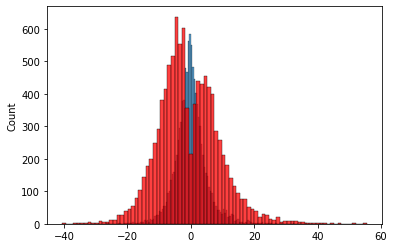

In [9]:
sns.histplot(linearized_likes_1)
sns.histplot(linearized_likes_2, color = 'r')

В новой метрике бимодальность во 2-ой группе ощутимо меньше.

Проведем t-тест между группами 1 и 2 по метрике линеаризованных лайков.

In [10]:
stats.ttest_ind(linearized_likes_1,
                linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

Проведем t-тест между группами 1 и 2 по обычному CTR.

In [11]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

p-value при использовании нового метода (pvalue=9.439432187037644e-10) стало сильно меньше по сравнению с обычным сравнением CTR (pvalue=0.4780623130874935). Различия между группами 1 и 2 по новой метрике, в отличии от поюзерного CTR по t-тесту, статистически значимы.

Посмотрим гистограмму распределения поюзерного CTR в исходных группах 0 и 3

<AxesSubplot:xlabel='ctr', ylabel='Count'>

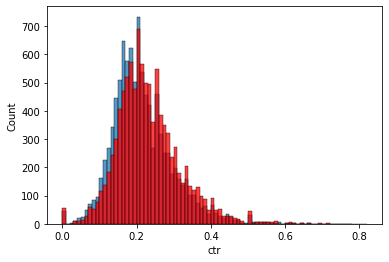

In [12]:
sns.histplot(df[df.exp_group == 0].ctr, binwidth = 0.01)
sns.histplot(df[df.exp_group == 3].ctr, color = 'r', binwidth = 0.01)

В данном случае бимодальность не наблюдается. Возможно p-value между этой и новой метрикой сильно различаться не будут.

Построим гистограмму распределения новой метрики для 0 и 3 групп.

<AxesSubplot:ylabel='Count'>

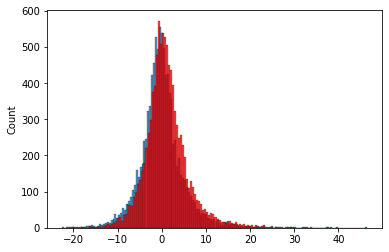

In [13]:
sns.histplot(linearized_likes_0)
sns.histplot(linearized_likes_3, color = 'r')

Проведем t-тест между группами 0 и 3 по метрике линеаризованных лайков.

In [14]:
stats.ttest_ind(linearized_likes_0,
                linearized_likes_3,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

Проведем t-тест между группами 0 и 3 по обычному CTR.

In [15]:
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

p-value при использовании нового метода (pvalue=5.4914249479690016e-52) стало меньше по сравнению с поюзерным сравнением CTR ( pvalue=1.055849414662529e-43), однако оба показателя сильно меньше 0.05. Различия между группами 0 и 3 по обоим показателям статистически значимы.